In [0]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from PIL import Image
import tensorflow as tf

In [2]:
!pip install tqdm
from tqdm import tqdm
tf.set_random_seed(10)
np.random.seed(10)

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('https://github.com/harveenchadha/dump-nn-tf/raw/master/Section2/NN_Predict_Fraud/train.csv')
df.head()
df.dropna(inplace=True)
x = df.iloc[:, :30]
y = df.iloc[:, -1:]

scl = StandardScaler()
x = scl.fit_transform(x)

In [0]:
def WeightsVariable(shape, name = 'weights'):
    return tf.Variable(tf.truncated_normal(shape, mean = 0.0, stddev=0.001, name=name))

def BiasVariable(shape, name = 'biases'):
    return tf.Variable(tf.constant(1.0, shape=[shape], name='biases'))

In [0]:
def network(images, channels = 1):
    num_c = [128, 64, 64, 64, 32, 128]

    with tf.name_scope('fc1'):
        weights = WeightsVariable([30, num_c[0]])
        biases = BiasVariable(num_c[0])
        fc1 = tf.nn.relu(tf.matmul(images, weights) + biases)
        
    with tf.name_scope('fc2'):
        weights = WeightsVariable([num_c[0], num_c[1]])
        biases = BiasVariable(num_c[1])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
        
    with tf.name_scope('fc3'):
        weights = WeightsVariable([num_c[1], num_c[2]])
        biases = BiasVariable(num_c[2])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
        
    with tf.name_scope('fc5'):
        weights = WeightsVariable([num_c[2], num_c[3]])
        biases = BiasVariable(num_c[3])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
        
    with tf.name_scope('fc6'):
        weights = WeightsVariable([num_c[3], num_c[4]])
        biases = BiasVariable(num_c[4])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)   

    with tf.name_scope('fc4'):
        weights = WeightsVariable([num_c[4], 1])
        biases = BiasVariable(1)
        fc2 = tf.matmul(fc1, weights) + biases
    return fc2

In [0]:
def loss_metrics(logits, labels):
    logits = logits
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
    return tf.reduce_mean(cross_entropy, name = 'softmax_mean')

In [0]:
#returns the optimizer by taking the loss
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate = STARTER_LR)
    train_op = optimizer.minimize(loss)
    return train_op
    

In [0]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, k = 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))#, accuracy1, accuracy2
  
def acc(logits, labels):
    correct_prediction = tf.equal(tf.cast(tf.greater_equal(logits,0.5), tf.float32) , labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    return accuracy

In [0]:
def placeholder_inputs(batch_size, shape = [30]):
    image_placeholder = tf.placeholder(tf.float32, shape = (None, shape[0]))
    label_placeholder = tf.placeholder(tf.float32, shape = (None))
    return image_placeholder, label_placeholder

In [0]:

loss_plot = []
acc_plot = []
train_plot = []
def run_training(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    with tf.Graph().as_default():

        images_pl, labels_pl = placeholder_inputs(BATCH_SIZE)
        logits = network(images_pl)
        print("Logits Calculated Successfully")
        loss = loss_metrics(logits = logits, labels = labels_pl)
        train_op = training(loss)
#         eval_correct = evaluation(logits, labels_pl)
        acc_val = acc(logits, labels_pl)
        summary = tf.summary.merge_all()
        
        init = tf.global_variables_initializer()
        
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) #OPTIONAL
        sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))
        
        saver = tf.train.Saver()
        sess.run(init)
        for steps in range(MAX_STEPS):
            loss_avg = []
            for i in tqdm(np.arange(0, len(x_train), BATCH_SIZE)):
                images_feed = x_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]
                labels_feed = y_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]

                feed_dict = { images_pl: np.reshape(images_feed, (-1, 30)), labels_pl: labels_feed }

                _ = sess.run([train_op], feed_dict = feed_dict)
                

            images_feed = x_test
            labels_feed = y_test

            feed_dict = {
                images_pl: np.reshape(images_feed, (-1, 30)),
                labels_pl: labels_feed
                        }
            loss_  = sess.run([loss], feed_dict = feed_dict)
            accuracy_val  = sess.run([acc_val], feed_dict = feed_dict)
            
            images_feed = x_train
            labels_feed = y_train

            feed_dict = {
                images_pl: np.reshape(images_feed, (-1, 30)),
                labels_pl: labels_feed
                        }
            train_loss  = sess.run([loss], feed_dict = feed_dict)
            
            loss_plot.append(loss_)
            train_plot.append(train_loss)
            acc_plot.append(accuracy_val)
            print('\t Loss %d: Training loss = %.5f  Validation loss = %.5f\t Validation Acc = %.5f' % (steps+1, train_loss[0], loss_[0], accuracy_val[0]))     
          
        return sess, images_pl, labels_pl, acc_val, logits

In [107]:
STARTER_LR = 6e-5
BATCH_SIZE = 3
NUM_CLASSES = 10
MAX_STEPS = 100

loss_plot = []
acc_plot = []
train_plot = []
sess, images_pl, labels_pl, eval_correct, logits = run_training(np.asarray(x, dtype = np.float32), np.asarray(y, dtype = np.int32))

Logits Calculated Successfully


 33%|███▎      | 80/240 [00:00<00:00, 797.48it/s]

	 Loss 1: Training loss = 0.75092  Validation loss = 0.78636	 Validation Acc = 0.46111


 32%|███▎      | 78/240 [00:00<00:00, 777.44it/s]

	 Loss 2: Training loss = 0.67083  Validation loss = 0.67569	 Validation Acc = 0.53889


 31%|███▏      | 75/240 [00:00<00:00, 742.55it/s]

	 Loss 3: Training loss = 0.63803  Validation loss = 0.63841	 Validation Acc = 0.53889


 30%|██▉       | 71/240 [00:00<00:00, 703.71it/s]

	 Loss 4: Training loss = 0.61184  Validation loss = 0.60962	 Validation Acc = 0.53889


 29%|██▉       | 70/240 [00:00<00:00, 697.56it/s]

	 Loss 5: Training loss = 0.58718  Validation loss = 0.58180	 Validation Acc = 0.62222


 30%|███       | 72/240 [00:00<00:00, 718.10it/s]

	 Loss 6: Training loss = 0.56532  Validation loss = 0.55680	 Validation Acc = 0.65556


 30%|███       | 73/240 [00:00<00:00, 722.91it/s]

	 Loss 7: Training loss = 0.54682  Validation loss = 0.53565	 Validation Acc = 0.66667


 31%|███▏      | 75/240 [00:00<00:00, 748.18it/s]

	 Loss 8: Training loss = 0.53101  Validation loss = 0.51816	 Validation Acc = 0.68889


 35%|███▍      | 83/240 [00:00<00:00, 825.87it/s]

	 Loss 9: Training loss = 0.51707  Validation loss = 0.50306	 Validation Acc = 0.70556


 33%|███▎      | 79/240 [00:00<00:00, 785.54it/s]

	 Loss 10: Training loss = 0.50498  Validation loss = 0.49025	 Validation Acc = 0.72778


 34%|███▍      | 82/240 [00:00<00:00, 818.91it/s]

	 Loss 11: Training loss = 0.49404  Validation loss = 0.47914	 Validation Acc = 0.73333


 34%|███▍      | 81/240 [00:00<00:00, 809.85it/s]

	 Loss 12: Training loss = 0.48402  Validation loss = 0.46925	 Validation Acc = 0.74444


 34%|███▍      | 81/240 [00:00<00:00, 809.73it/s]

	 Loss 13: Training loss = 0.47490  Validation loss = 0.46062	 Validation Acc = 0.76111


 36%|███▌      | 86/240 [00:00<00:00, 858.25it/s]

	 Loss 14: Training loss = 0.46653  Validation loss = 0.45283	 Validation Acc = 0.77222


 36%|███▌      | 86/240 [00:00<00:00, 855.80it/s]

	 Loss 15: Training loss = 0.45899  Validation loss = 0.44621	 Validation Acc = 0.77778


 34%|███▍      | 81/240 [00:00<00:00, 805.50it/s]

	 Loss 16: Training loss = 0.45182  Validation loss = 0.44005	 Validation Acc = 0.78333


 34%|███▍      | 82/240 [00:00<00:00, 816.22it/s]

	 Loss 17: Training loss = 0.44575  Validation loss = 0.43558	 Validation Acc = 0.79444


 34%|███▍      | 81/240 [00:00<00:00, 809.98it/s]

	 Loss 18: Training loss = 0.43957  Validation loss = 0.43050	 Validation Acc = 0.81111


 33%|███▎      | 79/240 [00:00<00:00, 785.48it/s]

	 Loss 19: Training loss = 0.43574  Validation loss = 0.42906	 Validation Acc = 0.81667


 34%|███▍      | 82/240 [00:00<00:00, 816.77it/s]

	 Loss 20: Training loss = 0.43017  Validation loss = 0.42480	 Validation Acc = 0.82222


 36%|███▌      | 86/240 [00:00<00:00, 855.99it/s]

	 Loss 21: Training loss = 0.42673  Validation loss = 0.42341	 Validation Acc = 0.83333


 33%|███▎      | 80/240 [00:00<00:00, 798.89it/s]

	 Loss 22: Training loss = 0.42191  Validation loss = 0.41994	 Validation Acc = 0.85556


 34%|███▍      | 81/240 [00:00<00:00, 809.20it/s]

	 Loss 23: Training loss = 0.41778  Validation loss = 0.41733	 Validation Acc = 0.86111


 34%|███▍      | 82/240 [00:00<00:00, 819.74it/s]

	 Loss 24: Training loss = 0.41278  Validation loss = 0.41359	 Validation Acc = 0.86111


 33%|███▎      | 79/240 [00:00<00:00, 785.19it/s]

	 Loss 25: Training loss = 0.41204  Validation loss = 0.41531	 Validation Acc = 0.87222


 35%|███▌      | 84/240 [00:00<00:00, 836.06it/s]

	 Loss 26: Training loss = 0.40827  Validation loss = 0.41298	 Validation Acc = 0.88333


 34%|███▍      | 82/240 [00:00<00:00, 817.70it/s]

	 Loss 27: Training loss = 0.40088  Validation loss = 0.40605	 Validation Acc = 0.88889


 35%|███▍      | 83/240 [00:00<00:00, 825.70it/s]

	 Loss 28: Training loss = 0.39550  Validation loss = 0.40171	 Validation Acc = 0.88889


 33%|███▎      | 80/240 [00:00<00:00, 796.49it/s]

	 Loss 29: Training loss = 0.39777  Validation loss = 0.40683	 Validation Acc = 0.89444


 35%|███▍      | 83/240 [00:00<00:00, 828.26it/s]

	 Loss 30: Training loss = 0.39452  Validation loss = 0.40499	 Validation Acc = 0.90000


 35%|███▌      | 84/240 [00:00<00:00, 838.32it/s]

	 Loss 31: Training loss = 0.38711  Validation loss = 0.39815	 Validation Acc = 0.90000


 35%|███▌      | 85/240 [00:00<00:00, 847.23it/s]

	 Loss 32: Training loss = 0.38675  Validation loss = 0.39981	 Validation Acc = 0.89444


 35%|███▌      | 85/240 [00:00<00:00, 847.85it/s]

	 Loss 33: Training loss = 0.38578  Validation loss = 0.40068	 Validation Acc = 0.90000


 35%|███▍      | 83/240 [00:00<00:00, 824.88it/s]

	 Loss 34: Training loss = 0.37918  Validation loss = 0.39476	 Validation Acc = 0.90556


 33%|███▎      | 79/240 [00:00<00:00, 786.67it/s]

	 Loss 35: Training loss = 0.37253  Validation loss = 0.38877	 Validation Acc = 0.90556


 35%|███▌      | 85/240 [00:00<00:00, 848.18it/s]

	 Loss 36: Training loss = 0.37030  Validation loss = 0.38802	 Validation Acc = 0.91111


 35%|███▌      | 84/240 [00:00<00:00, 834.76it/s]

	 Loss 37: Training loss = 0.36464  Validation loss = 0.38321	 Validation Acc = 0.91111


 33%|███▎      | 80/240 [00:00<00:00, 799.04it/s]

	 Loss 38: Training loss = 0.35884  Validation loss = 0.37828	 Validation Acc = 0.91111


 35%|███▍      | 83/240 [00:00<00:00, 829.96it/s]

	 Loss 39: Training loss = 0.35325  Validation loss = 0.37357	 Validation Acc = 0.91111


 35%|███▌      | 84/240 [00:00<00:00, 836.23it/s]

	 Loss 40: Training loss = 0.34925  Validation loss = 0.37073	 Validation Acc = 0.91667


 33%|███▎      | 80/240 [00:00<00:00, 799.29it/s]

	 Loss 41: Training loss = 0.34259  Validation loss = 0.36478	 Validation Acc = 0.91667


 35%|███▍      | 83/240 [00:00<00:00, 829.22it/s]

	 Loss 42: Training loss = 0.33972  Validation loss = 0.36324	 Validation Acc = 0.91667


 35%|███▌      | 84/240 [00:00<00:00, 839.52it/s]

	 Loss 43: Training loss = 0.32966  Validation loss = 0.35336	 Validation Acc = 0.91667


 34%|███▍      | 81/240 [00:00<00:00, 809.59it/s]

	 Loss 44: Training loss = 0.32096  Validation loss = 0.34511	 Validation Acc = 0.91667


 35%|███▌      | 85/240 [00:00<00:00, 849.93it/s]

	 Loss 45: Training loss = 0.31877  Validation loss = 0.34439	 Validation Acc = 0.91667


 35%|███▍      | 83/240 [00:00<00:00, 829.90it/s]

	 Loss 46: Training loss = 0.31128  Validation loss = 0.33759	 Validation Acc = 0.91667


 32%|███▎      | 78/240 [00:00<00:00, 774.52it/s]

	 Loss 47: Training loss = 0.30970  Validation loss = 0.33759	 Validation Acc = 0.91667


 34%|███▍      | 82/240 [00:00<00:00, 819.03it/s]

	 Loss 48: Training loss = 0.30028  Validation loss = 0.32860	 Validation Acc = 0.91667


 34%|███▍      | 82/240 [00:00<00:00, 819.22it/s]

	 Loss 49: Training loss = 0.30259  Validation loss = 0.33302	 Validation Acc = 0.91667


 33%|███▎      | 80/240 [00:00<00:00, 796.65it/s]

	 Loss 50: Training loss = 0.28616  Validation loss = 0.31599	 Validation Acc = 0.91667


 33%|███▎      | 80/240 [00:00<00:00, 799.25it/s]

	 Loss 51: Training loss = 0.29381  Validation loss = 0.32636	 Validation Acc = 0.91111


 35%|███▌      | 84/240 [00:00<00:00, 836.37it/s]

	 Loss 52: Training loss = 0.27737  Validation loss = 0.30894	 Validation Acc = 0.91667


 34%|███▍      | 81/240 [00:00<00:00, 808.72it/s]

	 Loss 53: Training loss = 0.28267  Validation loss = 0.31636	 Validation Acc = 0.91111


 35%|███▍      | 83/240 [00:00<00:00, 827.22it/s]

	 Loss 54: Training loss = 0.27174  Validation loss = 0.30521	 Validation Acc = 0.91111


 34%|███▍      | 82/240 [00:00<00:00, 817.96it/s]

	 Loss 55: Training loss = 0.27409  Validation loss = 0.30915	 Validation Acc = 0.91111


 34%|███▍      | 82/240 [00:00<00:00, 818.92it/s]

	 Loss 56: Training loss = 0.26352  Validation loss = 0.29834	 Validation Acc = 0.91111


 34%|███▍      | 82/240 [00:00<00:00, 818.57it/s]

	 Loss 57: Training loss = 0.25551  Validation loss = 0.29037	 Validation Acc = 0.91111


 35%|███▌      | 85/240 [00:00<00:00, 847.67it/s]

	 Loss 58: Training loss = 0.25915  Validation loss = 0.29566	 Validation Acc = 0.91667


 35%|███▍      | 83/240 [00:00<00:00, 828.74it/s]

	 Loss 59: Training loss = 0.24223  Validation loss = 0.27736	 Validation Acc = 0.91111


 35%|███▌      | 85/240 [00:00<00:00, 849.22it/s]

	 Loss 60: Training loss = 0.27892  Validation loss = 0.32001	 Validation Acc = 0.92778


 34%|███▍      | 82/240 [00:00<00:00, 818.68it/s]

	 Loss 61: Training loss = 0.23546  Validation loss = 0.27163	 Validation Acc = 0.91111


 35%|███▍      | 83/240 [00:00<00:00, 829.70it/s]

	 Loss 62: Training loss = 0.23521  Validation loss = 0.27235	 Validation Acc = 0.92222


 34%|███▍      | 82/240 [00:00<00:00, 818.80it/s]

	 Loss 63: Training loss = 0.24020  Validation loss = 0.27899	 Validation Acc = 0.92778


 34%|███▍      | 82/240 [00:00<00:00, 817.25it/s]

	 Loss 64: Training loss = 0.22525  Validation loss = 0.26284	 Validation Acc = 0.92778


 36%|███▌      | 86/240 [00:00<00:00, 852.02it/s]

	 Loss 65: Training loss = 0.23030  Validation loss = 0.26941	 Validation Acc = 0.92778


 35%|███▌      | 85/240 [00:00<00:00, 845.39it/s]

	 Loss 66: Training loss = 0.21919  Validation loss = 0.25761	 Validation Acc = 0.92778


 33%|███▎      | 80/240 [00:00<00:00, 799.67it/s]

	 Loss 67: Training loss = 0.21787  Validation loss = 0.25672	 Validation Acc = 0.92778


 35%|███▌      | 84/240 [00:00<00:00, 839.22it/s]

	 Loss 68: Training loss = 0.22298  Validation loss = 0.26329	 Validation Acc = 0.92778


 33%|███▎      | 80/240 [00:00<00:00, 794.41it/s]

	 Loss 69: Training loss = 0.20894  Validation loss = 0.24794	 Validation Acc = 0.92778


 35%|███▍      | 83/240 [00:00<00:00, 829.04it/s]

	 Loss 70: Training loss = 0.21792  Validation loss = 0.25891	 Validation Acc = 0.92778


 33%|███▎      | 79/240 [00:00<00:00, 788.68it/s]

	 Loss 71: Training loss = 0.25140  Validation loss = 0.29735	 Validation Acc = 0.93333


 33%|███▎      | 79/240 [00:00<00:00, 785.22it/s]

	 Loss 72: Training loss = 0.20003  Validation loss = 0.23944	 Validation Acc = 0.92778


 35%|███▍      | 83/240 [00:00<00:00, 825.37it/s]

	 Loss 73: Training loss = 0.20063  Validation loss = 0.24079	 Validation Acc = 0.92778


 35%|███▍      | 83/240 [00:00<00:00, 826.81it/s]

	 Loss 74: Training loss = 0.20164  Validation loss = 0.24254	 Validation Acc = 0.93333


 33%|███▎      | 79/240 [00:00<00:00, 786.60it/s]

	 Loss 75: Training loss = 0.22993  Validation loss = 0.27520	 Validation Acc = 0.92778


 35%|███▍      | 83/240 [00:00<00:00, 829.22it/s]

	 Loss 76: Training loss = 0.19841  Validation loss = 0.23985	 Validation Acc = 0.93333


 35%|███▌      | 84/240 [00:00<00:00, 836.06it/s]

	 Loss 77: Training loss = 0.18936  Validation loss = 0.22984	 Validation Acc = 0.93333


 35%|███▌      | 84/240 [00:00<00:00, 838.98it/s]

	 Loss 78: Training loss = 0.19194  Validation loss = 0.23334	 Validation Acc = 0.93333


 32%|███▎      | 78/240 [00:00<00:00, 774.88it/s]

	 Loss 79: Training loss = 0.19743  Validation loss = 0.24012	 Validation Acc = 0.92778


 35%|███▍      | 83/240 [00:00<00:00, 827.17it/s]

	 Loss 80: Training loss = 0.19103  Validation loss = 0.23317	 Validation Acc = 0.92778


 35%|███▌      | 84/240 [00:00<00:00, 839.15it/s]

	 Loss 81: Training loss = 0.19306  Validation loss = 0.23586	 Validation Acc = 0.92778


 33%|███▎      | 79/240 [00:00<00:00, 786.66it/s]

	 Loss 82: Training loss = 0.17912  Validation loss = 0.22029	 Validation Acc = 0.93333


 35%|███▍      | 83/240 [00:00<00:00, 826.12it/s]

	 Loss 83: Training loss = 0.17914  Validation loss = 0.22072	 Validation Acc = 0.93333


 34%|███▍      | 81/240 [00:00<00:00, 808.16it/s]

	 Loss 84: Training loss = 0.18905  Validation loss = 0.23270	 Validation Acc = 0.92778


 34%|███▍      | 81/240 [00:00<00:00, 806.54it/s]

	 Loss 85: Training loss = 0.17575  Validation loss = 0.21756	 Validation Acc = 0.92778


 35%|███▌      | 84/240 [00:00<00:00, 836.88it/s]

	 Loss 86: Training loss = 0.18077  Validation loss = 0.22391	 Validation Acc = 0.93333


 36%|███▌      | 86/240 [00:00<00:00, 859.53it/s]

	 Loss 87: Training loss = 0.17857  Validation loss = 0.22175	 Validation Acc = 0.93333


 35%|███▌      | 85/240 [00:00<00:00, 847.20it/s]

	 Loss 88: Training loss = 0.17641  Validation loss = 0.21959	 Validation Acc = 0.93333


 35%|███▌      | 85/240 [00:00<00:00, 845.36it/s]

	 Loss 89: Training loss = 0.17052  Validation loss = 0.21320	 Validation Acc = 0.93333


 34%|███▍      | 81/240 [00:00<00:00, 807.65it/s]

	 Loss 90: Training loss = 0.18185  Validation loss = 0.22697	 Validation Acc = 0.92778


 35%|███▍      | 83/240 [00:00<00:00, 827.54it/s]

	 Loss 91: Training loss = 0.16798  Validation loss = 0.21099	 Validation Acc = 0.93333


 35%|███▌      | 85/240 [00:00<00:00, 845.14it/s]

	 Loss 92: Training loss = 0.17046  Validation loss = 0.21451	 Validation Acc = 0.93333


 32%|███▎      | 78/240 [00:00<00:00, 774.51it/s]

	 Loss 93: Training loss = 0.17036  Validation loss = 0.21494	 Validation Acc = 0.93333


 36%|███▌      | 86/240 [00:00<00:00, 858.59it/s]

	 Loss 94: Training loss = 0.17428  Validation loss = 0.22005	 Validation Acc = 0.92222


 36%|███▌      | 86/240 [00:00<00:00, 856.17it/s]

	 Loss 95: Training loss = 0.16810  Validation loss = 0.21308	 Validation Acc = 0.93333


 33%|███▎      | 79/240 [00:00<00:00, 785.45it/s]

	 Loss 96: Training loss = 0.16397  Validation loss = 0.20863	 Validation Acc = 0.93333


 35%|███▌      | 84/240 [00:00<00:00, 839.48it/s]

	 Loss 97: Training loss = 0.16391  Validation loss = 0.20921	 Validation Acc = 0.93333


 35%|███▍      | 83/240 [00:00<00:00, 825.90it/s]

	 Loss 98: Training loss = 0.17289  Validation loss = 0.22013	 Validation Acc = 0.92778


 34%|███▍      | 82/240 [00:00<00:00, 818.11it/s]

	 Loss 99: Training loss = 0.16109  Validation loss = 0.20649	 Validation Acc = 0.93333


100%|██████████| 240/240 [00:00<00:00, 1143.17it/s]

	 Loss 100: Training loss = 0.16004  Validation loss = 0.20591	 Validation Acc = 0.93333


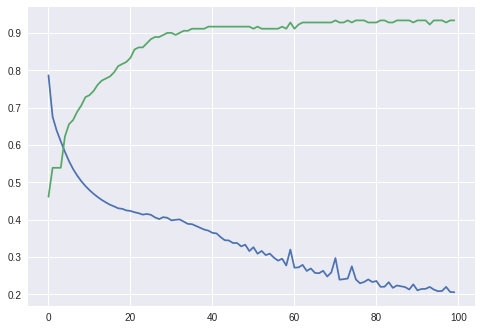

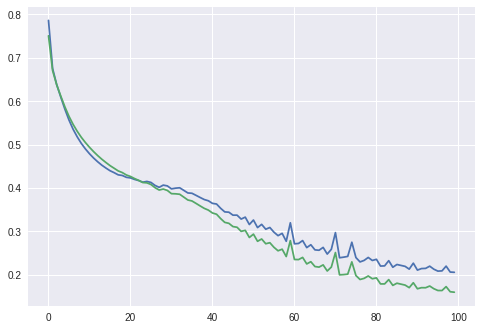

In [108]:
sns.set_style("darkgrid")
plt.plot(loss_plot)
plt.plot(acc_plot)
plt.show()
plt.plot(loss_plot)
plt.plot(train_plot)

In [0]:
images_feed, labels_feed = MNIST_DATASETS.validation.images, MNIST_DATASETS.validation.labels

feed_dict = {
    images_pl: np.reshape(images_feed, (-1, 28, 28, 1))
            }
with sess.as_default():
  accuracy  = sess.run([logits], feed_dict = feed_dict)
  
  preds = np.argmax(accuracy[0], 1)
  print(preds)

[5 0 4 ... 2 1 2]


In [0]:
from sklearn.metrics import classification_report
print(classification_report(labels_feed, preds))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       479
          1       0.97      0.98      0.97       563
          2       0.98      0.93      0.96       488
          3       0.98      0.96      0.97       493
          4       0.98      0.98      0.98       535
          5       0.96      0.98      0.97       434
          6       0.98      0.98      0.98       501
          7       0.96      0.97      0.97       550
          8       0.96      0.97      0.97       462
          9       0.96      0.96      0.96       495

avg / total       0.97      0.97      0.97      5000



In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_feed, preds))

[[473   0   0   0   0   2   2   0   0   2]
 [  0 553   2   2   1   0   1   2   2   0]
 [  1  10 454   5   1   1   0   7   8   1]
 [  0   1   2 475   0   7   0   5   2   1]
 [  0   1   0   0 526   0   4   1   0   3]
 [  0   1   1   0   1 427   0   0   3   1]
 [  3   2   0   0   1   1 493   0   1   0]
 [  0   2   2   1   3   0   0 536   0   6]
 [  0   2   0   1   0   3   1   2 449   4]
 [  2   1   0   2   5   2   0   7   2 474]]


In [0]:
# graph = tf.GraphDef()
# graph.ParseFromString(tf_model.SerializeToString())

# with tf.Graph().as_default() as graph:
#         # The name var will prefix every op/nodes in your graph
#         # Since we load everything in a new graph, this is not needed
#     tf.import_graph_def(graph, name="prefix")
    
    